[View in Colaboratory](https://colab.research.google.com/github/vivianistan/mbti-classification/blob/master/mbti.ipynb)

# Preprocessing: 

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import re
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [0]:
!pip install -q xgboost==0.4a30
import xgboost as xgb

In [0]:
!pip install -q nltk
import nltk

In [0]:
!pip install -q spaCy
import spacy

In [5]:
!python -m spacy download en

    100% |████████████████████████████████| 37.4MB 56.3MB/s 
  Running setup.py install for en-core-web-sm ... - \ | done

    Linking successful
    /usr/local/lib/python2.7/dist-packages/en_core_web_sm -->
    /usr/local/lib/python2.7/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')



In [17]:
# Uploading files: 
from google.colab import files
uploaded = files.upload()

Saving mbti_1.csv to mbti_1 (1).csv


In [18]:
df_train = pd.read_csv('mbti_1.csv')
df_train.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [19]:
print(df_train.columns)

Index([u'type', u'posts'], dtype='object')


In [9]:
# Check for null data
print('Train columns with null values:\n', df_train.isnull().sum())

('Train columns with null values:\n', type     0
posts    0
dtype: int64)


/usr/local/lib/python2.7/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


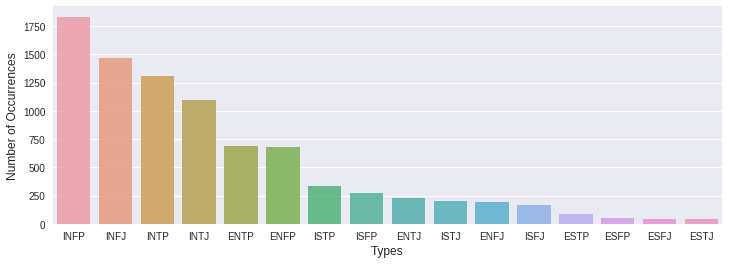

In [10]:
# How many of each type? (https://www.kaggle.com/lbronchal/what-s-the-personality-of-kaggle-users)
cnt_srs = df_train['type'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

Very unbalanced data set

In [0]:
one_hot_encoded_training_predictors = pd.get_dummies(df_train)
# one_hot_encoded_training_predictors

NLTK processing: 


In [24]:
# import nltk
# nltk.download('stopwords'),nltk.download('porter_test'), nltk.download('punkt')

[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package porter_test to /content/nltk_data...
[nltk_data]   Unzipping stemmers/porter_test.zip.
[nltk_data] Downloading package punkt to /content/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


(True, True, True)

In [0]:
from nltk import word_tokenize

Helpful link for using spaCy: 
* https://nlpforhackers.io/complete-guide-to-spacy/ 
* https://spacy.io/usage/linguistic-features#section-pos-tagging


List of part of speech tags: https://stackoverflow.com/questions/1833252/java-stanford-nlp-part-of-speech-labels 


Common part of speech tags:

| Tag  | Meaning | English example  |
| --- |---| ---|
| JJ | adjective | new, good, special |
| IN | adposition     |   on, of, at, under |
| RB| adverb  | really, early, already
|CC|conjunction|and, or, but, if, although
|DET|determiner/article |the, a, some, most, which
|NN| noun|year, home, time
|NNP| proper noun| Madrid, Paris, Austin
|VB*|verb| is, run, play
|NUM| numeral| twenty, 12, 2018, 12:32
|PRP|preposition|my, I, we
|UH| interjection| Ah! wow!
|.| punctuation| ?, !, .


In [27]:
# Part of speech tagging example:
import spacy

raw = 'wow! the quick brown fox jumped over the sleeping dog right then'

nlp = spacy.load('en')
doc = nlp(unicode(raw))
print([(token.text, token.tag_) for token in doc])



[(u'wow', u'UH'), (u'!', u'.'), (u'the', u'DT'), (u'quick', u'JJ'), (u'brown', u'JJ'), (u'fox', u'NN'), (u'jumped', u'VBD'), (u'over', u'IN'), (u'the', u'DT'), (u'sleeping', u'VBG'), (u'dog', u'NN'), (u'right', u'RB'), (u'then', u'RB')]


In [28]:
# Idea: count avg number of NN, JJ, etc. per comment 
num_JJ = num_NN = num_PRP =  num_VB = num_NNP = num_DT = 0
for token in doc:
  if token.tag_ == 'NN': 
    num_NN +=1
    
print(num_NN)

2


## Feature engineering: 

Add features: 
* words per comment
* variance of word counts
* number of different parts of speech (determiners, articles, adjectives, adverbs, pronouns, punctuation marks (?!))
* links per comment
* images per comment
* ellipsis per comment



reference: https://www.kaggle.com/laowingkin/mbti-study-personality 

In [99]:
# From kaggle: add words per comment/variance of word counts 
def var_row(row):
    l = []
    for i in row.split('|||'):
        l.append(len(i.split()))
    return np.var(l)

# add features:
df_train['words_per_comment'] = df_train['posts'].apply(lambda x: len(x.split())/50.0)
df_train['variance_of_word_counts'] = df_train['posts'].apply(lambda x: var_row(x))

df_train['http_per_comment'] = df_train['posts'].apply(lambda x: x.count('http')/50.0)
df_train['img_per_comment'] = df_train['posts'].apply(lambda x: x.count('jpg')/50.0)

df_train['qm_per_comment'] = df_train['posts'].apply(lambda x: x.count('?')/50.0)
df_train['excl_per_comment'] = df_train['posts'].apply(lambda x: x.count('!')/50.0)
df_train['ellipsis_per_comment'] = df_train['posts'].apply(lambda x: x.count('...')/50.0)

df_train['E'] = df_train['type'].apply(lambda x: x.count('E'))
df_train['I'] = df_train['type'].apply(lambda x: x.count('I'))

df_train['S'] = df_train['type'].apply(lambda x: x.count('S'))
df_train['N'] = df_train['type'].apply(lambda x: x.count('N'))

df_train['F'] = df_train['type'].apply(lambda x: x.count('F'))
df_train['T'] = df_train['type'].apply(lambda x: x.count('T'))

df_train['P'] = df_train['type'].apply(lambda x: x.count('P'))
df_train['J'] = df_train['type'].apply(lambda x: x.count('J'))

df_train.head()

,type,posts,words_per_comment,variance_of_word_counts,http_per_comment,img_per_comment,qm_per_comment,excl_per_comment,ellipsis_per_comment,E,I,S,N,F,T,J,P
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,135.2900,0.48,0.12,0.36,0.06,0.30,0,1,0,1,1,0,1,0
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,187.4756,0.20,0.02,0.10,0.00,0.38,1,0,0,1,0,1,0,1
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,180.6900,0.10,0.00,0.24,0.08,0.26,0,1,0,1,0,1,0,1
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,181.8324,0.04,0.00,0.22,0.06,0.52,0,1,0,1,0,1,1,0
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,196.4576,0.12,0.04,0.20,0.02,0.42,1,0,0,1,0,1,1,0


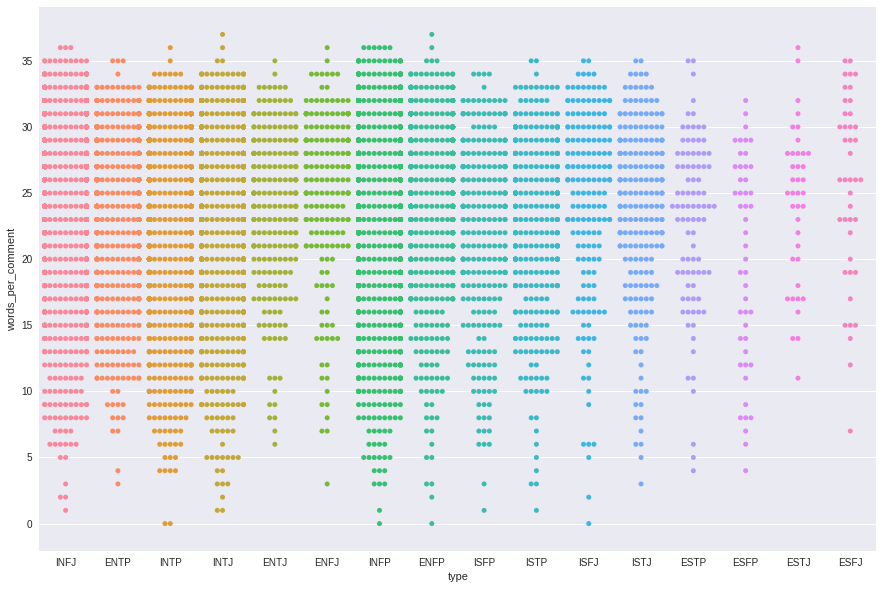

In [22]:
plt.figure(figsize=(15,10))
sns.swarmplot("type","words_per_comment", data=df_train)

## Trying Some Models (w.r.t. E vs. I, S vs. N, F vs. T, J vs. P)

xgboost of course





In [33]:
import sklearn

from sklearn.model_selection import train_test_split
from sklearn import cross_validation

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [0]:
# X = df_train.drop(['type'],axis = 1)
# y = df_train['type'].iloc(0,:)

# one hot encode type
# type_dummies = pd.get_dummies(df_train['type'])

# X = df_train.drop(['type'],axis = 1).join(type_dummies)
# y = df_train['type']

In [0]:
# Extrovert/Introvert set
X_e = df_train.drop(['posts', 'type','E','I','S','N','F','T','P','J'], 1)
y_e = df_train['E']

In [0]:
# Sensing/Intuition set
X_s = df_train.drop(['posts', 'type','E','I','S','N','F','T','P','J'], 1)
y_s = df_train['S']

In [0]:
# Feeling/Thinking set
X_f = df_train.drop(['posts', 'type','E','I','S','N','F','T','P','J'], 1)
y_f = df_train['F']

In [0]:
# Judging/Perceiving set
X_j = df_train.drop(['posts', 'type','E','I','S','N','F','T','P','J'], 1)
y_j = df_train['J']

In [0]:
# Split the data set into a training set and a test set.
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_e, y_e, test_size = 0.3, random_state = 0)

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size = 0.3, random_state = 0)

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_f, y_f, test_size = 0.3, random_state = 0)

X_train_j, X_test_j, y_train_j, y_test_j = train_test_split(X_j, y_j, test_size = 0.3, random_state = 0)

In [117]:
model_xgb_e = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=250)
model_xgb_e.fit(X_train_e, y_train_e)

model_xgb_s = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=250)
model_xgb_s.fit(X_train_s, y_train_s)

model_xgb_f = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=250)
model_xgb_f.fit(X_train_f, y_train_f)

model_xgb_j = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=250)
model_xgb_j.fit(X_train_j, y_train_j)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=5, missing=None, n_estimators=250, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

## Feature Selection:

Let's see which features are most important: 

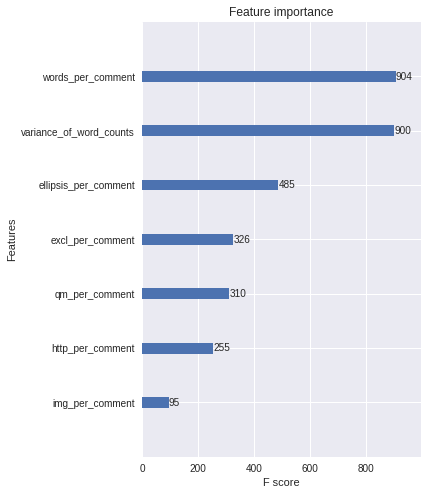

In [118]:
# Extrovert/Introvert
fig, ax = plt.subplots(figsize=(5,8))
xgb.plot_importance(model_xgb_e, ax=ax)
plt.show()

Looks like the most important features for determining if someone is an extrovert is words_per_comment, variance_of_word_counts, and ellipsis_per_comment

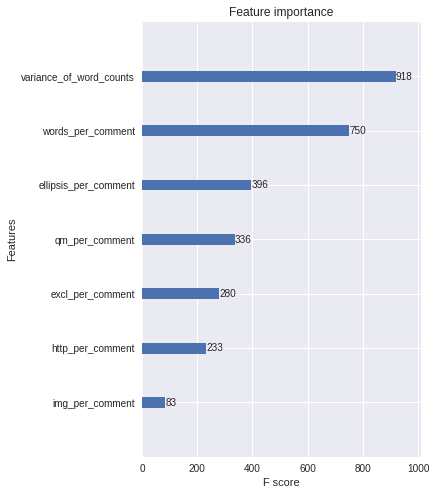

In [119]:
# For Sensing/Intuition
fig, ax = plt.subplots(figsize=(5,8))
xgb.plot_importance(model_xgb_s, ax=ax)
plt.show()

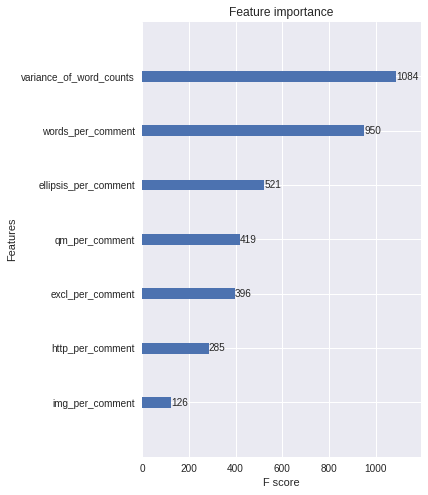

In [120]:
# Thinking/Feeling
fig, ax = plt.subplots(figsize=(5,8))
xgb.plot_importance(model_xgb_f, ax=ax)
plt.show()

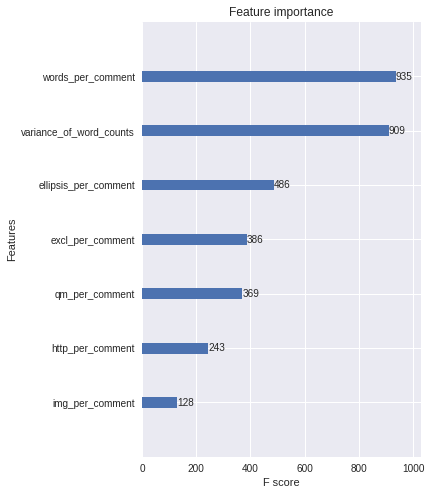

In [121]:
# Judging/Perceiving
fig, ax = plt.subplots(figsize=(5,8))
xgb.plot_importance(model_xgb_j, ax=ax)
plt.show()